### Problem Set 5

As usual, you are highly encouraged to *start this problem set early!*  Our best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with data structures, so if you're going to get stuck, get stuck (and unstuck) early!

Note that the extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

In addition to numpy, pandas, sklearn and matplotlib, we suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life much easier:-

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block. You may also import additional functions/classes if you need them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#You can go over the scikit-learn documentation to learn more about what some of these functions and classes
from  sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import IPython

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  We have downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  We have also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies.

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for 2020's [Oscar winner](https://www.rottentomatoes.com/m/parasite_2019) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Let's start by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')
movies = movies.dropna()
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
reviews = reviews[~reviews.critic.isna()]

### 1.1: Basic features of the dataset

Answer the following questions by having your Python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many different publications have reviews in the `reviews` dataset?
* How many unique movies are in the `movies` dataset?
* What is the year range in the `movies` dataset? 
* What is the lowest `rtAudienceScore` for the year 1995 in the `movies` dataset?


In [3]:
# enter your code below

print("Number of unique reviews are: {}".format(reviews['quote'].nunique()))
print("Number of unique critics: {}".format(reviews.critic.nunique()))
print("Number of unique movies in reviews: {}".format(reviews.imdb.nunique()))
print("Number of Publication in reviews df: {}".format(reviews.publication.nunique()))
print("Number of unique movies in movies: {}".format(movies.title.nunique()))
print("Year Range in movies: {} years".format(max(movies.year)-min(movies.year)))
print("Lowest rtAudienceScore 1995 : {}".format(min(movies[movies.year==1995].rtAudienceScore)))

Number of unique reviews are: 12149
Number of unique critics: 540
Number of unique movies in reviews: 1715
Number of Publication in reviews df: 64
Number of unique movies in movies: 8959
Year Range in movies: 108 years
Lowest rtAudienceScore 1995 : 0


### 1.2 Number of reviews per critic

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per critic.  Have the bin width (x-axis) be 5 units wide, and the range of the x-axis to be from 0 to 100.  Scale the y-axis to show the logarithm of the (count of) the number of critics.  Also add a vertical line at the average number of reviews per critic. 

Label your axes and make your histogram look professional.

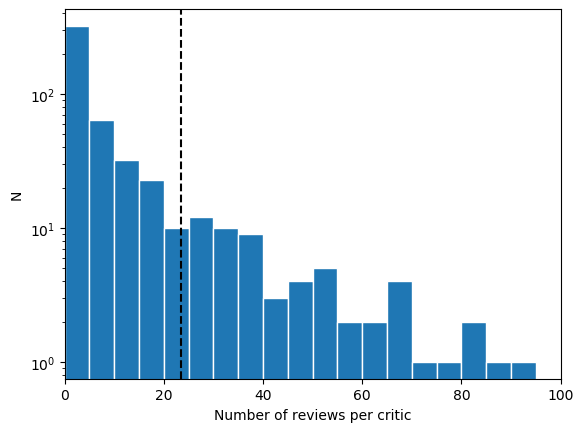

In [4]:
plt.style.use('default')

rev_per = reviews.groupby('critic').rtid.count()
rev_per.hist(log=True, bins=np.arange(0, 100, 5), edgecolor='white')
plt.axvline(np.mean(reviews.groupby('critic').rtid.count()), color='k', linestyle='--')
plt.xlabel("Number of reviews per critic")
plt.ylabel("N")
plt.xlim([0,100])
plt.grid(False)

### 1.3 Zoom in on a few reviewers
Find the 25 critics with the most reviews, and list their names in a table along with -

* (a) The name(s) of *all* the publications they work for. If a critic happens to work for more than one publication, you should have a comma-separated string that contains all publications for that critic.
* (b) The date of their first review.
* (c) The date of their last review.
* (d) The total number of reviews (count).

Sort the table in descending order of the number of reviews.

*Hint: The `apply`, `merge` and `groupby` functions can be useful here*

In [5]:
# enter your code here
reviewer_top_25 = rev_per.sort_values(ascending=False)[:25].index.tolist()
review_top_25 = reviews[reviews.critic.isin(reviewer_top_25)]
reviewer_group_1 = review_top_25.groupby(['critic','publication']).size().reset_index()
reviewer_group_2 = reviewer_group_1.groupby('critic').apply(lambda x: ', '.join(x['publication'])).reset_index()
reviewer_group_2.columns = ['critic', 'publication']
review_date = review_top_25.groupby('critic')['review_date'].agg(first_review='min', last_review='max', count = 'count').reset_index()
review_date.merge(reviewer_group_2, on='critic', how='inner')[['critic', 'publication', 'first_review', 'last_review', 'count']].sort_values(by='count', ascending=False)

,critic,publication,first_review,last_review,count
19,Roger Ebert,"At the Movies, Chicago Sun-Times",2000-01-01 00:00:00,2013-06-11 00:00:00,1150
7,James Berardinelli,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00,833
8,Janet Maslin,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00,526
23,Variety Staff,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00,449
10,Jonathan Rosenbaum,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00,420
3,Desson Thomson,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00,373
5,Geoff Andrew,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00,361
1,Dave Kehr,"Chicago Reader, Chicago Tribune, New York Dail...",2000-01-01 00:00:00,2013-11-20 00:00:00,360
11,Kenneth Turan,Los Angeles Times,2000-01-01 00:00:00,2013-10-05 00:00:00,282
14,Mick LaSalle,San Francisco Chronicle,2000-01-01 00:00:00,2009-11-25 00:00:00,280


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average movie rating has evolved over time. Refer to `rtAllCriticsRating` for each movie's rating. 

Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is `rtAllCriticsRating`.  Drop movies with 0 or unknown values to simplify the analysis.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in red showing how the average movie rating (the average of `rtAllCriticsRating` across all movies in a year) has changed over time.  

Do you notice a trend?  What do you think it means?

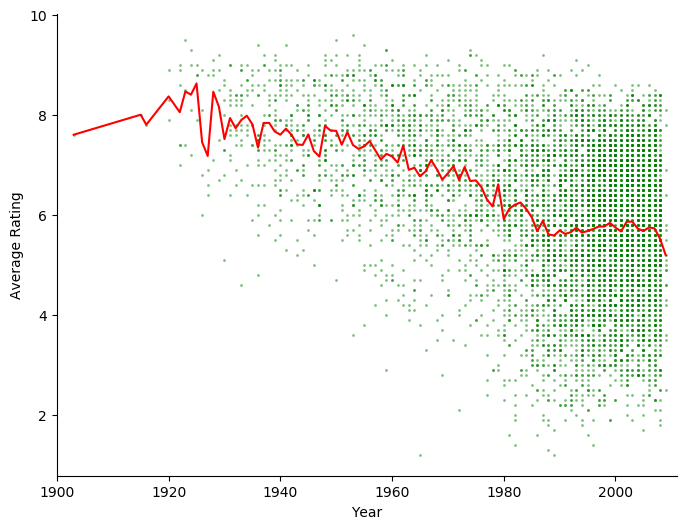

In [6]:
# enter your code here
movies_2 = movies[movies.rtAllCriticsRating != '\\N']
movies_2.loc[:,'rtAllCriticsRating'] = movies_2['rtAllCriticsRating'].astype(float)
movies_2 = movies_2[movies_2.rtAllCriticsRating > 0]

a = movies_2.groupby('year')['rtAllCriticsRating'].mean()
movies_3 = pd.DataFrame({'year': a.index.tolist(), 'avg_rate': a.tolist()})
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(movies_2['year'], movies_2['rtAllCriticsRating'], 'o', c='g', markersize=2, markeredgecolor='none', alpha=0.5)
ax.plot(movies_3['year'], movies_3['avg_rate'], '-', c='red')
plt.xlabel('Year')
plt.ylabel('Average Rating')
ax.set_xlim(1900,2011)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

This graph shows a trend towards a lower average rating, as well as a greater abundance of low ratings, with time. This is probably at least partially a selection effect -- Rotten Tomatoes probably doesn't archive reviews for all movies, especially ones that came out before the website existed. Thus, reviews of old movies are more often "the classics". Mediocre old movies have been partially forgotten, and are underrepresented in the data. It's also possible the critics have gotten more critical -- without further anaylsis, it's hard to know what is causing the trend.

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes Classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is:-\n", '\n'.join(text))
print()
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("Transformed text vector is \n", x)
print()
# `get_feature_names` tracks which word is associated with each column of the transformed x
print("Words for each feature:-")
print(vectorizer.get_feature_names())

Original text is:-
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:-
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where -
    
 * X is an **(nreview, nwords)** array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is an **nreview**-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text, if any.

In [8]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    #Your code here 
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(reviews.quote)
    X = X.toarray() 
    Y = (reviews.fresh == 'fresh').values.astype(np.int)
    return X, Y


In [9]:
X, Y = make_xy(reviews)
X,Y

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array([1, 1, 1, ..., 0, 0, 0]))

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set (80%) and a validation set (20%).  You can do this manually, as you did in the prior problem set, or use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  If you use `train_test_split`, set the `random_state` to 42, and have the split be stratified.

In [10]:
# enter your code here
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print(xtrain.shape, xtest.shape)
print(xtest.shape,ytest.shape)

(10174, 20267) (2544, 20267)
(2544, 20267) (2544,)


### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results.

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# enter your code here

# call the fitted model fitted_model, for future reference:
clf = MultinomialNB()
fitted_model = clf.fit(xtrain, ytrain)

print("Accuracy on training data:",accuracy_score(clf.predict(xtrain),ytrain))
print("Precision on training data:",precision_score(clf.predict(xtrain),ytrain))
print("Recall on training data:",recall_score(clf.predict(xtrain),ytrain))
print()
print("Accuracy on test data:",accuracy_score(clf.predict(xtest),ytest))
print("Precision on test data:",precision_score(clf.predict(xtest),ytest))
print("Recall on test data:",recall_score(clf.predict(xtest),ytest))

Accuracy on training data: 0.9270689994102614
Precision on training data: 0.9663469098914924
Recall on training data: 0.9208751685898396

Accuracy on test data: 0.7669025157232704
Precision on test data: 0.8522012578616353
Recall on test data: 0.791009924109749


The substantial gap in performance between training and testing datasets suggests that we are likely overfitting our model.

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on bcourses).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [12]:
# Your code here

--------------------------------------------

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [13]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# change the names of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, xtest, ytest)

-1484.6226919350697

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our methods have a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha`](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) keyword in the Bayesian classifier is the "smoothing parameter" that we discussed in class -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

How does the choice of these hyperparameters affect the performance of the model?

*Hints:* 
* sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here. You can use 5-fold CV. If you go this route, you'll want to  the scoring function to be the custom likelihood function defined earlier.
* For CV we only use the training set. This means in every iteration, for every combination of alpha and min_df, you will need to re-split into training and test sets. 

In [14]:
#You will want to suppress the warnings, since there might be a lot of them in this block. If you want to view them, change
# the 'ignore' to 'default' or 'once'
import warnings
warnings.filterwarnings('ignore')


#the grid of parameters to search over
alphas = [0, 1, 5, 10, 50]
min_dfs = [0.0001,0.001,0.01, 0.1, 0.2]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        #your code here
        xtrain, _, ytrain , _ = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
        model = MultinomialNB(alpha = alpha)
        score = cross_val_score(model, xtrain, ytrain, scoring=log_likelihood, cv=5).mean()
        print("alpha: {:.2f}, min_df: {:.6f}, L: {:.2f}".format(alpha, min_df, score))
        if score > max_loglike : 
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df

print("best alpha, best min_dfs: ",best_alpha, best_min_df)

alpha: 0.00, min_df: 0.000100, L: -12041.87
alpha: 0.00, min_df: 0.001000, L: -1969.26
alpha: 0.00, min_df: 0.010000, L: -1266.58
alpha: 0.00, min_df: 0.100000, L: -1323.94
alpha: 0.00, min_df: 0.200000, L: -1330.68
alpha: 1.00, min_df: 0.000100, L: -1126.97
alpha: 1.00, min_df: 0.001000, L: -1150.83
alpha: 1.00, min_df: 0.010000, L: -1265.55
alpha: 1.00, min_df: 0.100000, L: -1323.94
alpha: 1.00, min_df: 0.200000, L: -1330.68
alpha: 5.00, min_df: 0.000100, L: -1478.95
alpha: 5.00, min_df: 0.001000, L: -1095.86
alpha: 5.00, min_df: 0.010000, L: -1262.56
alpha: 5.00, min_df: 0.100000, L: -1323.91
alpha: 5.00, min_df: 0.200000, L: -1330.69
alpha: 10.00, min_df: 0.000100, L: -2138.36
alpha: 10.00, min_df: 0.001000, L: -1138.96
alpha: 10.00, min_df: 0.010000, L: -1260.68
alpha: 10.00, min_df: 0.100000, L: -1323.89
alpha: 10.00, min_df: 0.200000, L: -1330.69
alpha: 50.00, min_df: 0.000100, L: -3192.36
alpha: 50.00, min_df: 0.001000, L: -1949.58
alpha: 50.00, min_df: 0.010000, L: -1280.73
al

We obtain the best alpha at 5, and best min_df at 0.001. Note how min_df does not affect model performance a lot, while an alpha value from 0-5 shows an improvement but beyond 5 it mostly reduces performances. There is no directly observable trend, except for the point at which we have the best performance.

### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy on training and test sets.  Discuss the various ways in which cross-validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [15]:
#Enter your code here

vectorizer = CountVectorizer(min_df=best_min_df)
X, Y = make_xy(reviews, vectorizer)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

print("Accuracy on training data:",accuracy_score(clf.predict(xtrain),ytrain))
print("Precision on training data:",precision_score(clf.predict(xtrain),ytrain))
print("Recall on training data:",recall_score(clf.predict(xtrain),ytrain))
print()
print("Accuracy on test data:",accuracy_score(clf.predict(xtest),ytest))
print("Precision on test data:",precision_score(clf.predict(xtest),ytest))
print("Recall on test data:",recall_score(clf.predict(xtest),ytest))

Accuracy on training data: 0.7972282288185571
Precision on training data: 0.8748230853907847
Recall on training data: 0.8144948755490483

Accuracy on test data: 0.726808176100629
Precision on test data: 0.8182389937106919
Recall on test data: 0.7621558289396603


We observe that the accuracy is lower of this tuned model than it was prior to implementing cross-validation. This may be due to the fact that less data is available to train the model than in the setting without cross-validation. It is also partly due to the fact that we are optimizing for log-likelihood here, which is not quite the same as accuracy -- more on this below.  Also noteworthy is the fact that the performance on the training and testing datasets has converged significantly, suggesting that overfitting, while not eliminated, is better than it was absent cross-validation.

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [16]:
#Enter your code here
best_alpha2 = None
best_min_df2 = None
acc = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizertemp = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizertemp)
        
        #your code here
        xtraint, _, ytraint , _ = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
        model = MultinomialNB(alpha = alpha)
        score = cross_val_score(model, xtraint, ytraint, scoring="accuracy", cv=5).mean()
        print("alpha: {:.2f}, min_df: {:.6f}, L: {:.2f}".format(alpha, min_df, score))
        if score > acc : 
            acc = score
            best_alpha = alpha
            best_min_df = min_df

print("best alpha, best min_dfs: ",best_alpha, best_min_df)

alpha: 0.00, min_df: 0.000100, L: 0.73
alpha: 0.00, min_df: 0.001000, L: 0.74
alpha: 0.00, min_df: 0.010000, L: 0.66
alpha: 0.00, min_df: 0.100000, L: 0.62
alpha: 0.00, min_df: 0.200000, L: 0.62
alpha: 1.00, min_df: 0.000100, L: 0.77
alpha: 1.00, min_df: 0.001000, L: 0.74
alpha: 1.00, min_df: 0.010000, L: 0.66
alpha: 1.00, min_df: 0.100000, L: 0.62
alpha: 1.00, min_df: 0.200000, L: 0.62
alpha: 5.00, min_df: 0.000100, L: 0.71
alpha: 5.00, min_df: 0.001000, L: 0.74
alpha: 5.00, min_df: 0.010000, L: 0.66
alpha: 5.00, min_df: 0.100000, L: 0.62
alpha: 5.00, min_df: 0.200000, L: 0.62
alpha: 10.00, min_df: 0.000100, L: 0.66
alpha: 10.00, min_df: 0.001000, L: 0.73
alpha: 10.00, min_df: 0.010000, L: 0.66
alpha: 10.00, min_df: 0.100000, L: 0.62
alpha: 10.00, min_df: 0.200000, L: 0.62
alpha: 50.00, min_df: 0.000100, L: 0.63
alpha: 50.00, min_df: 0.001000, L: 0.63
alpha: 50.00, min_df: 0.010000, L: 0.66
alpha: 50.00, min_df: 0.100000, L: 0.62
alpha: 50.00, min_df: 0.200000, L: 0.62
best alpha, bes

In [17]:
#Enter your code here

vectorizer1 = CountVectorizer(min_df=best_min_df)
X1, Y1 = make_xy(reviews, vectorizer1)
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(X1, Y1, test_size=0.2, random_state=42, stratify=Y)

clf2 = MultinomialNB(alpha=best_alpha).fit(xtrain1, ytrain1)

print("Accuracy on training data:",accuracy_score(clf2.predict(xtrain1),ytrain1))
print("Precision on training data:",precision_score(clf2.predict(xtrain1),ytrain1))
print("Recall on training data:",recall_score(clf2.predict(xtrain1),ytrain1))
print()
print("Accuracy on test data:",accuracy_score(clf2.predict(xtest1),ytest1))
print("Precision on test data:",precision_score(clf2.predict(xtest1),ytest1))
print("Recall on test data:",recall_score(clf2.predict(xtest1),ytest1))

Accuracy on training data: 0.9081973658344801
Precision on training data: 0.9344236515175341
Recall on training data: 0.9199566496361666

Accuracy on test data: 0.7641509433962265
Precision on test data: 0.8220125786163522
Recall on test data: 0.8048029556650246


We see better performance on the test set when compared to 3.3, which means the classification accuracy might be a better scoring function as compared to log-likelihood.

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method (classifier and vectorizer from 3.3), determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [19]:
# Enter your code here
words = np.array(vectorizer.get_feature_names())

x = np.identity(xtest.shape[1])

probs = clf.predict_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\tP(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:20s}\t{:.2f}".format(w, 1 - p))
    
print("Bad words\tP(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:20s}\t{:.2f}".format(w, 1 - p))

Good words	P(fresh | word)
delight             	0.90
masterpiece         	0.89
extraordinary       	0.89
touching            	0.88
succeeds            	0.87
moving              	0.87
beautifully         	0.86
complex             	0.86
intelligent         	0.86
intimate            	0.86
Bad words	P(fresh | word)
worst               	0.24
formulaic           	0.23
tiresome            	0.22
pointless           	0.21
uninspired          	0.20
disappointment      	0.19
bland               	0.17
lame                	0.16
dull                	0.16
unfortunately       	0.13


In [18]:
# Enter your code here
words = np.array(vectorizer.get_feature_names())

x = np.identity(xtest.shape[1])

probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\tP(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:20s}\t{:.2f}".format(w, 1 - np.exp(p)))
    
print("Bad words\tP(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:20s}\t{:.2f}".format(w, 1 - np.exp(p)))

Good words	P(fresh | word)
delight             	0.90
masterpiece         	0.89
extraordinary       	0.89
touching            	0.88
succeeds            	0.87
moving              	0.87
beautifully         	0.86
complex             	0.86
intelligent         	0.86
intimate            	0.86
Bad words	P(fresh | word)
worst               	0.24
formulaic           	0.23
tiresome            	0.22
pointless           	0.21
uninspired          	0.20
disappointment      	0.19
bland               	0.17
lame                	0.16
dull                	0.16
unfortunately       	0.13


The ten words predicting rotten review and the 10 words predicting fresh reveiws make sense. The rotten reviews usually cover negative words, while fresh reviews cover positive words.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [20]:
#Your code here
x, y = make_xy(reviews, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(reviews[y == 0].reset_index()['quote'][row])
    print()

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(reviews[y == 1].reset_index()['quote'][row])
    print()
    
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

Mis-predicted Rotten quotes
---------------------------
It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

Mis-predicted Fresh quotes
-----

array([[0.02231255, 0.97768745]])

Many mis-predictions seem due to the fact that the quotes use more ambivalent language -- quotes along the lines of "this should have been a good movie, but it wasn't". Words like "but", "not", etc. act to negate the sentiment of words. However, because Naive Bayes treats each word separately, it isn't able to capture these kind of word interactions. Because the quote "this movie is not remarkable, touching, or superb in any way" contains typically positive words like remarkabke/touching/superb, the classifier gives it P(Fresh)=0.98, and it completely misses the context in the presence of the word 'not' before them. 

### 3.7 (Extra Credit) Word2Vec

Let's try something different now.

[Word2Vec](https://en.wikipedia.org/wiki/Word2vec) is a popular algorithm based on a shallow neural network, that can use large amounts of unannotated plain text, to learn relationships between words automatically. This is often very useful in recommender systems, text tagging or machine translation. Let's try to implement a basic version of this for our reviews data and observe some interesting (and natural) relationships between words. 

You will be using a new dataset which contains IMDB reviews, since we need a sufficiently large dataset and the Rotten Tomatoes dataset we have won't suffice. Download the data from [here](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). Train a Word2Vec model on these reviews and try to do the following - 

* From 3.5, pick 3 words that best predict a "fresh" review, and another 3 words that best predict a "rotten" review. For each of these words, find and print the top 10 most similar words from the vocabulary. 
* Spot the odd one out! Use the model to find the odd word from each of these input lists of words- 
    * 'amazing','great','awesome','horrible'
    * 'movie','cinema','theater','box'
    * 'car','bike','ball','bus'
    
    
Do you think this model is able to learn representations of words within a given context? Feel free to play around with the model and report any other interesting findings.


NOTE - 
* You should use the [*gensim*](https://radimrehurek.com/gensim/index.html) library for this question. [This](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) link contains all the details you need to get familarized with Word2Vec.
* It is highly recommended to pre-process your input data before feeding it to the model. Most common pre-processing steps include changing to lower case, removing punctuations, removing non-alphabetic tokens and removing stop words. You may find the [*nltk*](https://www.nltk.org/) library very useful for this, but feel free to use any other library. You can run the below block to import these libraries (you may have to pip install if you do not have these already installed).
* gensim provides access to pre-trained models ; **do not use a pre-trained model**. You should train the model yourself, and this will not take too long to run.
* We recommend you set an embedding size of 100-200 and a window of 4 or 5 for the model.

In [33]:
import string
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import *

In [22]:
#your code below

In [47]:
review_all = []
text = reviews_imdb['review'].values.tolist()

for line in text : 
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens] #to lower case
    table = str.maketrans('','', string.punctuation) #remove punctuations
    stripped = [w.translate(table) for w in tokens] 
    words = [word for word in stripped if word.isalpha()] #remove remaining tokens that are not alphabetic
    stop_words = set(stopwords.words('english')) #remove stop words
    words = [w for w in words if not w in stop_words]
    review_all.append(words)

In [48]:
len(review_all)

50000

In [49]:
model = gensim.models.Word2Vec(sentences=review_all, size=500, window=5, workers=4, min_count=5)
words = list(model.wv.vocab)
print('Vocab Size:', len(words))

Vocab Size: 40744


In [56]:
for word in ['delight','masterpiece','extraordinary','worst','formulaic','tiresome']:
    print(word)
    display(model.wv.most_similar(word))
    print('\n\n')

delight


[('delightful', 0.7209144234657288),
 ('joy', 0.7046644687652588),
 ('pleasure', 0.611587405204773),
 ('unforgettable', 0.6008260846138),
 ('enchanting', 0.5998257398605347),
 ('treat', 0.5903377532958984),
 ('joyful', 0.5851457118988037),
 ('wonderful', 0.5827125310897827),
 ('showcases', 0.57830411195755),
 ('heartwarming', 0.5736860036849976)]




masterpiece


[('kurosawa', 0.7120881080627441),
 ('cinematic', 0.7097176909446716),
 ('epic', 0.7085784673690796),
 ('kubrick', 0.6827366352081299),
 ('achievement', 0.6715531349182129),
 ('mustsee', 0.6635087728500366),
 ('miyazaki', 0.6472912430763245),
 ('gem', 0.6348357200622559),
 ('definitive', 0.633341908454895),
 ('argento', 0.620615541934967)]




extraordinary


[('remarkable', 0.8298016786575317),
 ('astonishing', 0.7606353759765625),
 ('masterful', 0.7428362369537354),
 ('powerful', 0.726060152053833),
 ('delicate', 0.7238725423812866),
 ('vivid', 0.7223660945892334),
 ('exceptional', 0.7221299409866333),
 ('inspiring', 0.7198083996772766),
 ('astounding', 0.7172242403030396),
 ('splendid', 0.7168548107147217)]




worst


[('stupidest', 0.7903246879577637),
 ('scariest', 0.7274532318115234),
 ('dumbest', 0.7063261270523071),
 ('funniest', 0.6859517097473145),
 ('best', 0.6812798976898193),
 ('lamest', 0.6583494544029236),
 ('cheesiest', 0.6148443818092346),
 ('greatest', 0.6095564961433411),
 ('weirdest', 0.5994590520858765),
 ('poorest', 0.5898404121398926)]




formulaic


[('unoriginal', 0.8802440166473389),
 ('derivative', 0.8738350868225098),
 ('clichéd', 0.8702373504638672),
 ('hackneyed', 0.8616941571235657),
 ('trite', 0.8518995046615601),
 ('predictability', 0.8277497887611389),
 ('unimaginative', 0.821486234664917),
 ('melodramatic', 0.8204681873321533),
 ('uninspired', 0.8080410957336426),
 ('simplistic', 0.8023625612258911)]




tiresome


[('monotonous', 0.8240743279457092),
 ('tedious', 0.8212651014328003),
 ('repetitive', 0.801179051399231),
 ('repetitious', 0.785454511642456),
 ('plodding', 0.752043604850769),
 ('melodramatic', 0.7461220026016235),
 ('muddled', 0.7460613250732422),
 ('stale', 0.7450498342514038),
 ('uninteresting', 0.7353368997573853),
 ('dull', 0.7352632284164429)]

In [57]:
model.wv.doesnt_match("amazing great awesome horrible".split())

'horrible'

In [58]:
model.wv.doesnt_match("movie cinema theater box".split())

'box'

In [59]:
model.wv.doesnt_match("car bike ball bus".split())

'ball'